In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (f1_score, roc_auc_score, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay,
                             roc_curve, average_precision_score, accuracy_score,classification_report)

In [3]:
df = pd.read_csv('../data/TotalFeatures-ISCXFlowMeter.csv')

## Characteristic Selection

### Random Forest for characteristic selection

In [30]:
# Function to evaluate model performance
def evaluate_model(model, train_features, train_target, test_features, test_target,classes):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 12)) 
    
    # Binarize classes for multiclass ROC and PRC

    n_classes = len(classes)
    train_target_binarized = label_binarize(train_target,classes=range(n_classes))
    test_target_binarized = label_binarize(test_target,classes=range(n_classes))
    
    for type, features, target_encoded, target_binarized in (
        ('train', train_features, train_target,train_target_binarized),
        ('test', test_features, test_target, test_target_binarized)
        ):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)

        # Calculate overall accuracy
        accuracy = accuracy_score(target_encoded,pred_target)
        eval_stats[type]['Accuracy'] = accuracy

        # Calculate and print classification report
        class_report = classification_report(target_encoded,pred_target,target_names=classes, output_dict=True)
        eval_stats[type]['Precision'] = class_report['weighted avg']['precision']
        eval_stats[type]['Recall'] = class_report['weighted avg']['recall']
        eval_stats[type]['F1'] = class_report['weighted avg']['f1-score']
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot confusion Matrix
        ax = axs[0,0] if type == 'train' else axs[1,0]
        cm = confusion_matrix(target_encoded,pred_target)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=ax,cmap='Blues')
        ax.set_title(f'{type.capitalize()} Confusion Matrix')

         #Plot Roc curves
        ax = axs[0,1] if type == 'train' else axs[1,1]
        for i in range(n_classes):
            fpr,tpr, _ = roc_curve(target_binarized[:,i],pred_proba[:,i])
            roc_auc = roc_auc_score(target_binarized[:,i],pred_proba[:,i])
            ax.plot(fpr,tpr,label=f'Class {classes[i]} (AUC={roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{type.capitalize()} ROC Curve')
        ax.legend(loc='lower right')

        # Plot precission recall curves
        ax = axs[0,2] if type == 'train' else axs[1,2]
        for i in range(n_classes):
            precission, recall, _ = precision_recall_curve(target_binarized[:, i], pred_proba[:, i])
            aps = average_precision_score(target_binarized[:, i], pred_proba[:, i])
            ax.plot(recall, precission,label=f'Class {classes[i]} (AP={aps:.2f})')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{type.capitalize()} Precision-Recall Curve')
        ax.legend(loc='upper right')
    
    df_eval_stats = pd.DataFrame(eval_stats).round(2)    
    print(df_eval_stats.reindex(index=('Accuracy', 'Precision', 'Recall', 'F1')))
    plt.tight_layout()
    plt.show()

In [10]:
# We create a function to divide our dataset

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [11]:
# We create a function do devide features from target
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [12]:
# We use the train_test_split to devide or dataset 
train_set, test_set, valid_set = train_val_test_split(df)

In [13]:
# We devide into features and target
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(valid_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

In [14]:
# We encode our targets using label enconder
l_e = LabelEncoder()
y_train = l_e.fit_transform(y_train)
y_val = l_e.fit_transform(y_val)
y_test = l_e.fit_transform(y_test)

In [15]:
# We create and train our model 
seed = 42
rf_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=seed)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [27]:
# We make predictions using the valid_set
y_pred = rf_model.predict(X_val)

# We print the score

print("F1 score:", f1_score(y_pred, y_val, average='weighted'))

F1 score: 0.9338861387255095


           train  test
Accuracy    0.98  0.93
Precision   0.98  0.93
Recall      0.98  0.93
F1          0.98  0.93


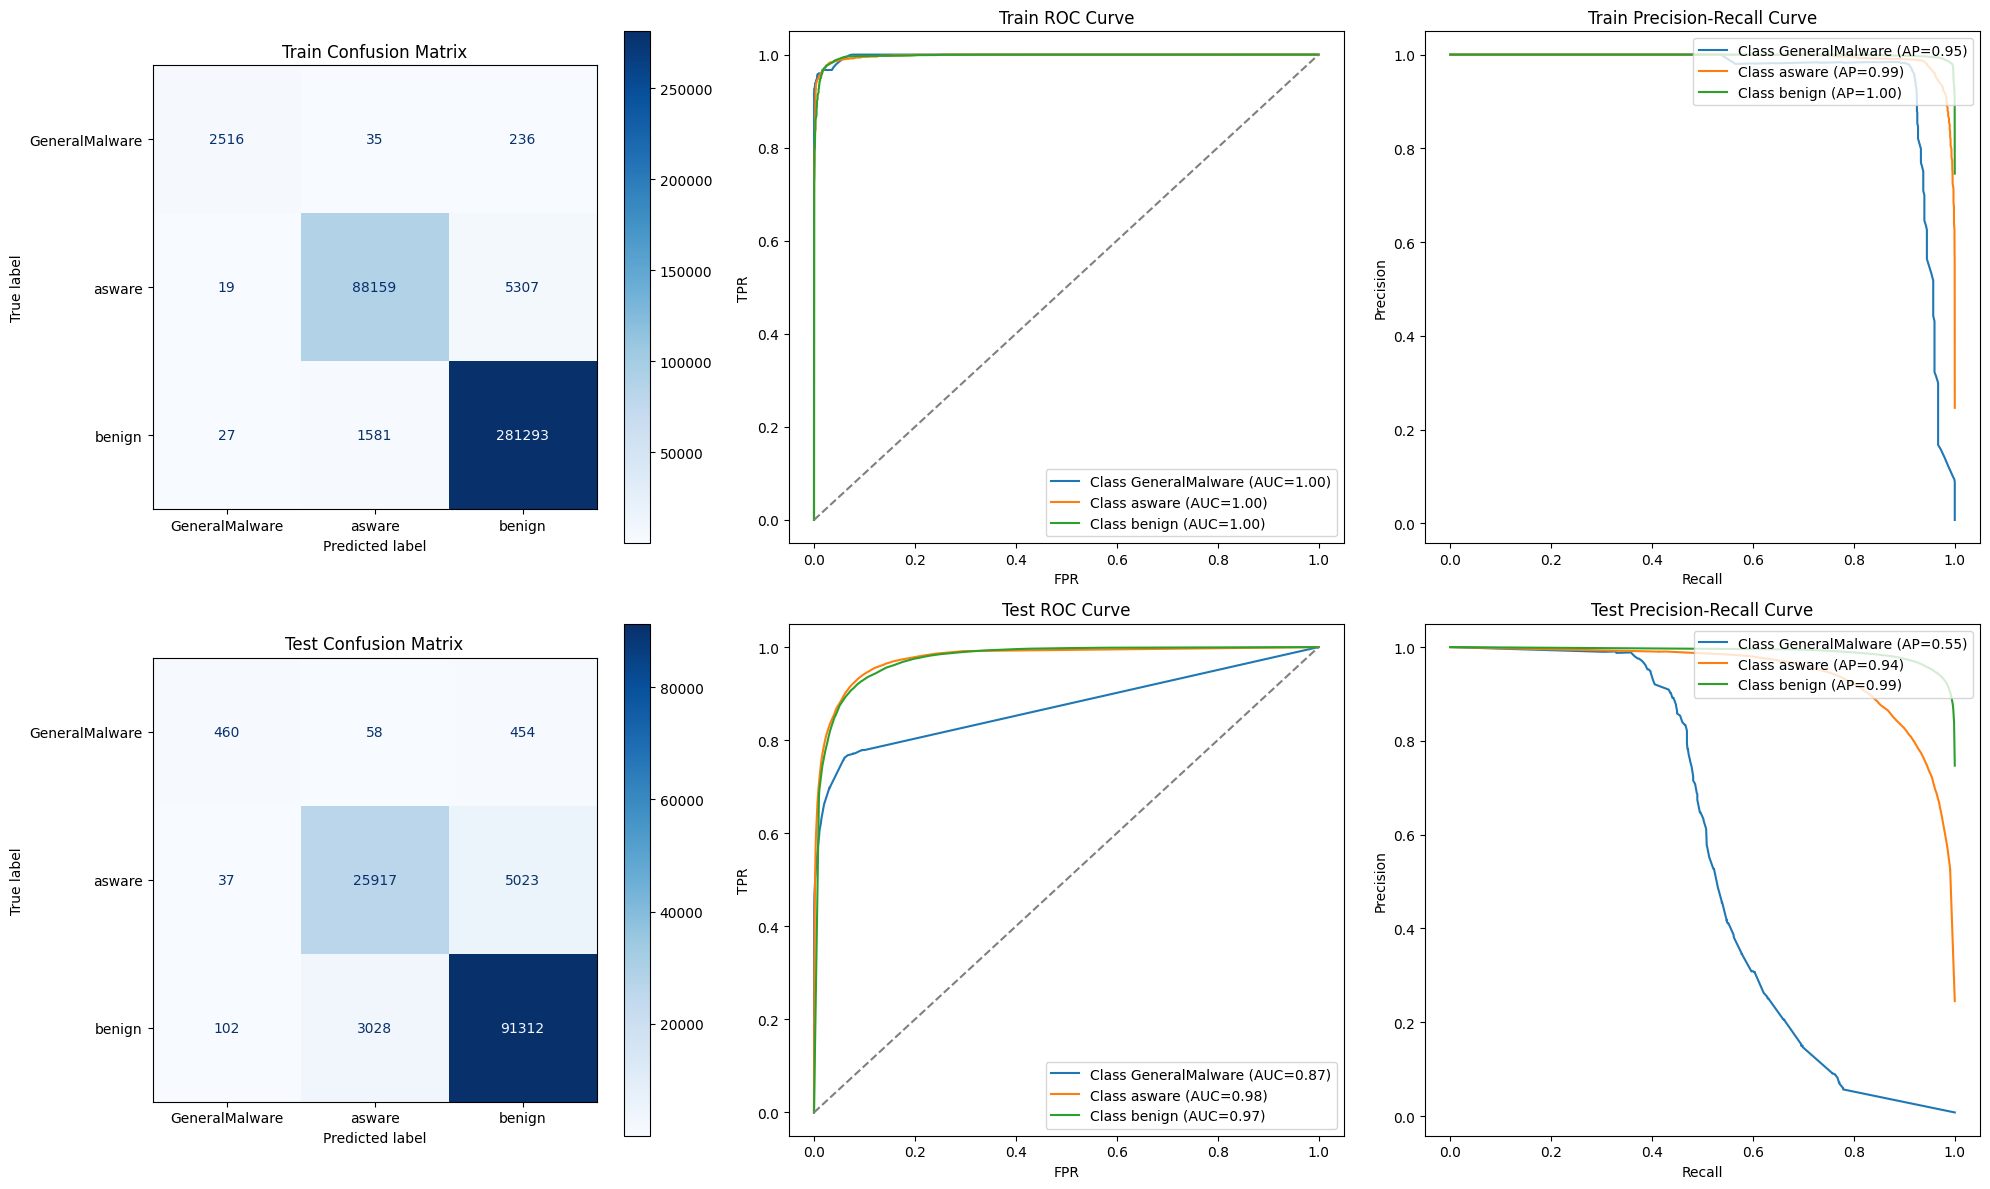

In [31]:
# Evaluate performance
evaluate_model(rf_model,X_train, y_train, X_test, y_test,l_e.classes_)

In [32]:
# Feature importance
feature_importances = {name: score for name, score in zip(list(df), rf_model.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

Init_Win_bytes_forward     0.141411
max_flowiat                0.038883
flow_fin                   0.033005
Init_Win_bytes_backward    0.031345
duration                   0.030967
mean_flowiat               0.030040
fPktsPerSecond             0.029483
flowBytesPerSecond         0.027684
flowPktsPerSecond          0.027376
min_flowpktl               0.026106
mean_flowpktl              0.024706
total_fpktl                0.023182
avgPacketSize              0.022515
max_fpktl                  0.021993
min_flowiat                0.020008
fAvgSegmentSize            0.019386
mean_fpktl                 0.019103
total_fiat                 0.018641
min_seg_size_forward       0.017701
bPktsPerSecond             0.017591
dtype: float64

### Reducing Characteristics

In [33]:
# We select the first 10 characteristics regarding their importance in the rf_model
columns_reduced = list(feature_importances_sorted.head(10).index)
columns_reduced

['Init_Win_bytes_forward',
 'max_flowiat',
 'flow_fin',
 'Init_Win_bytes_backward',
 'duration',
 'mean_flowiat',
 'fPktsPerSecond',
 'flowBytesPerSecond',
 'flowPktsPerSecond',
 'min_flowpktl']

In [41]:
X_train_reduced = X_train[columns_reduced].copy()
X_val_reduced = X_val[columns_reduced].copy()
X_test_reduced = X_test[columns_reduced].copy()

In [37]:
# Using gridserach to find the best model
model_forest = RandomForestClassifier()
param_grid = {
    'n_estimators':[20, 50, 100],
    'criterion':['gini', 'entropy'],
    'max_depth':[10, 20, 30],
    'class_weight':[None, 'balanced']
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, n_jobs=-1)
grid_forest.fit(X_train_reduced, y_train)

print(f'''
Best params:{ grid_forest.best_params_}        
Best score: {grid_forest.best_score_} 
''')


Best params:{'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}        
Best score: 0.9613613759671464 



In [38]:
rf_pred = grid_forest.best_estimator_.predict(X_val_reduced)
print("F1 score:", f1_score(rf_pred, y_val, average='weighted')) 

F1 score: 0.9290937484176955


           train  test
Accuracy    0.96  0.93
Precision   0.96  0.93
Recall      0.96  0.93
F1          0.96  0.92


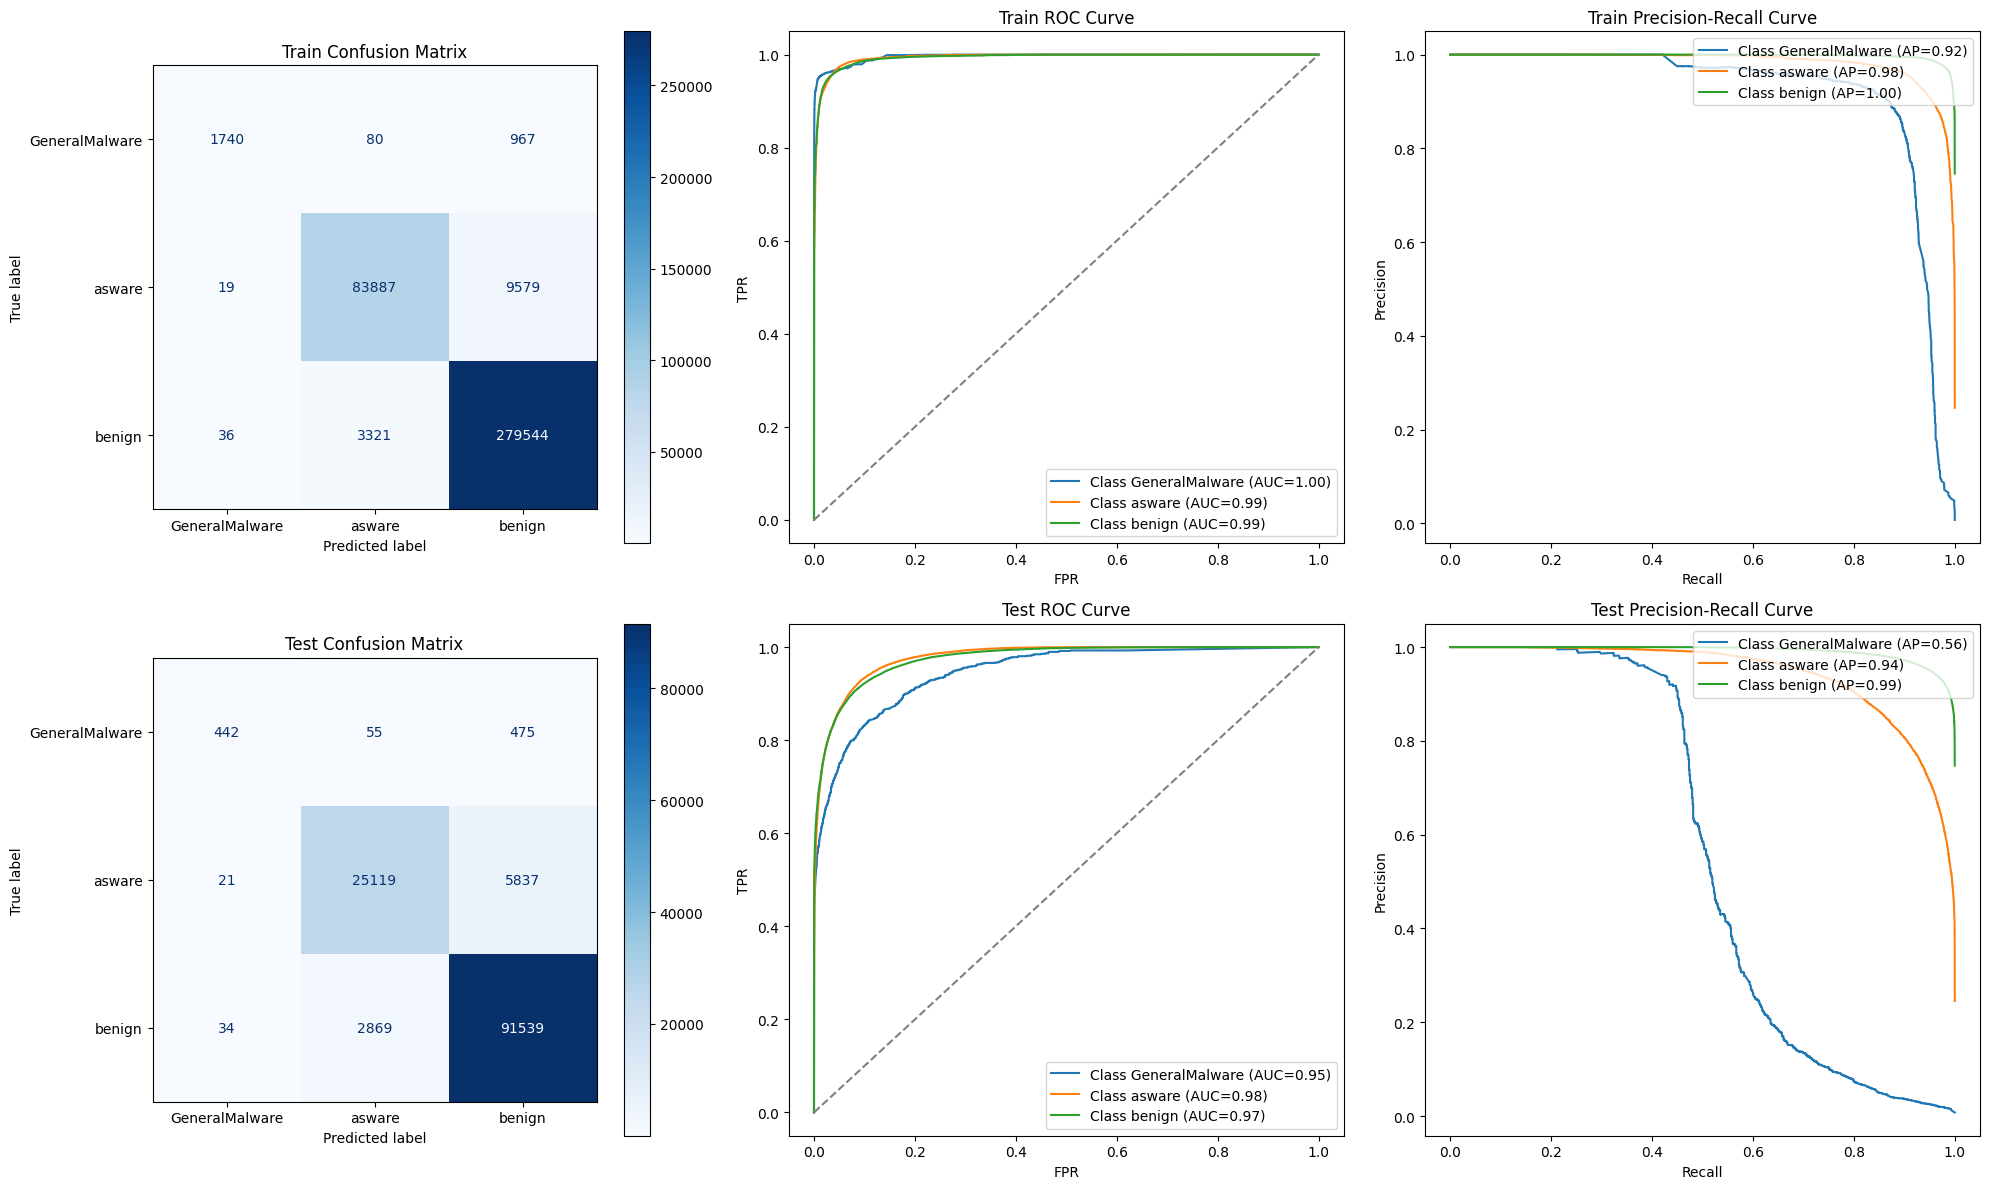

In [43]:
evaluate_model((grid_forest.best_estimator_),X_train_reduced, y_train, X_test_reduced, y_test,l_e.classes_)